In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import pickle

In [2]:
import sys
# setting path
sys.path.append('../')

from ruins.processing import drain_cap

In [3]:
# load primary data
data = xr.load_dataset('../data/hydro_krummh.nc').to_dataframe()
data.head()

,Prec_dissagg_1,Prec_dissagg_2,Prec_dissagg_3,Prec_dissagg_4,Prec_dissagg_5,Prec_dissagg_6,Prec_dissagg_7,Prec_dissagg_8,Prec_dissagg_9,Prec_dissagg_10,...,Prec_dissagg_77,Prec_dissagg_78,Prec_dissagg_79,Prec_dissagg_80,Prec,wl_Knock_Outer,wl_LW,wl_Knock_Inner,Knock_pump_obs,Q_Knock
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1325.000000,NaN,NaN,NaN
2011-01-01 01:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1325.000000,NaN,NaN,NaN
2011-01-01 02:00:00,0.0,0.0,0.0,0.491553,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,-1319.090942,NaN,NaN,NaN
2011-01-01 03:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1315.000000,NaN,NaN,NaN
2011-01-01 04:00:00,0.0,0.0,0.0,0.038447,0.0,0.240214,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1310.877563,NaN,NaN,NaN


In [4]:
#load cached events
with open('cache/events.pkl', 'rb') as file:
    events = pickle.load(file)
with open('cache/canals.pkl', 'rb') as file:
    canal_par = pickle.load(file)
with open('cache/pump.pkl', 'rb') as file:
    pumpcap_fit = pickle.load(file)

# Description of Scenarios

## Uncertainty in precipitation patters - Temporal aggregation-disaggregation

In [6]:
z = "2018-01-03"

t1 = events[z]
t2 = events[z]+datetime.timedelta(days=14)
days = (t2-t1).days
hours = days*24 + 1

tide = data['wl_Knock_Outer'][t1:t2]
wig = tide*0     # no wind induced gradient -> this may be used to simulate a local flooding in a subcatchment
x = pd.DataFrame.from_dict(
    {        
        'h_tide' : tide.fillna(100),
        'wig' : wig.fillna(0),
        'store_obs' : data['wl_LW'][t1:t2].fillna(-2200)
    }
)
if x.index[0].month in [10,11,12,1,2,3,4]:
    target = -1300
else:
    target = -1200

for raindissagg in data.filter(regex='Prec').columns:
    hourly_recharge = data[raindissagg][t1:t2]
    hourly_recharge = hourly_recharge.rolling("12h").mean() # smoothen rainfall signal to account for water redistribution within catchment

    x['recharge'] = hourly_recharge.fillna(0)

    
    maxdh = 4500
    Canal_area = 4
    advance_pump = 0

    for zzz in [canal_par[0]]:
        x['h_store'+str(raindissagg)], q_pump, h_min, flow_rec, pump_cost, store = drain_cap.storage_model(forcing_data = x,
                                                                                                 canal_par = zzz,
                                                                                                 v_store = 0,
                                                                                                 h_store_target = target,
                                                                                                 canal_area = Canal_area,
                                                                                                 h_forecast_pump = advance_pump,
                                                                                                 h_grad_pump_max = maxdh,
                                                                                                 pump_par = pumpcap_fit)
x = x[x>-2000]

C:\p\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


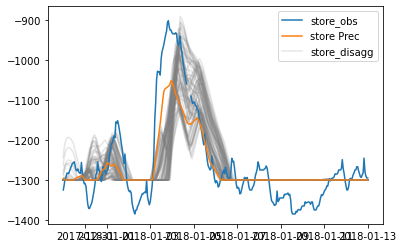

In [8]:
fig, ax = plt.subplots()

ax.plot(x.filter(regex = "dissagg"), color = "grey", alpha = 0.2)#.plot(ylabel = "Water level [mNN]", title = "dH_geo = "+str(maxdh)+" mm", legend = False)
ax.plot(x.store_obs, label = "store_obs")
ax.plot(x.h_storePrec, label = "store Prec")
ax.plot(x.filter(regex = "dissagg_80"), color = "grey", alpha = 0.2, label = "store_disagg")#.plot(ylabel = "Water level [mNN]", title = "dH_geo = "+str(maxdh)+" mm", legend = False)

ax.legend()

#x.filter(regex = "store").max(axis = 0).hist()
fig.show()
#x.filter(regex = "store").plot(ylabel = "Water level [mNN]", title = "dH_geo = "+str(maxdh)+" mm", legend = False)

## SLR

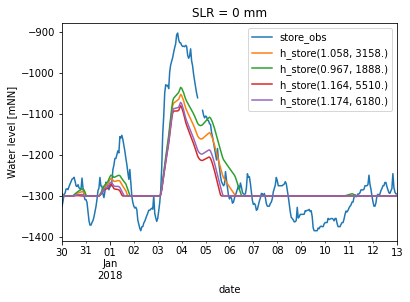

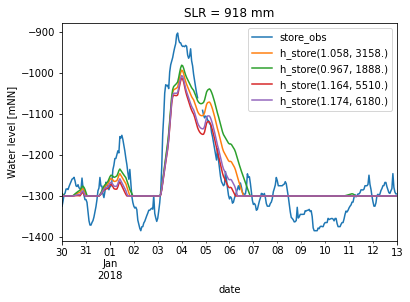

In [13]:
for SLR in [0,918]: # set SLR
    z = "2018-01-03"
    maxdh = 4500
    t1 = events[z]
    t2 = events[z]+datetime.timedelta(days=14)

    hourly_recharge = data["Prec"][t1:t2]
    days = (t2-t1).days
    hours = days*24 + 1

    tide = data['wl_Knock_Outer'][t1:t2]

    hourly_recharge = hourly_recharge.rolling("12h").mean() # smoothen rainfall signal to account for water redistribution within catchment

    wig = tide*0     # no wind induced gradient -> this may be used to simulate a local flooding in a subcatchment
    x = pd.DataFrame.from_dict(
        {        
            'recharge' : hourly_recharge.fillna(0),
            'h_tide' : tide.fillna(100)+SLR,
            'wig' : wig.fillna(0),
            'store_obs' : data['wl_LW'][t1:t2].fillna(-2200)
        }
    )

    if x.index[0].month in [10,11,12,1,2,3,4]:
        target = -1300
    else:
        target = -1200

#    maxdh = 4500
    Canal_area = 4
    advance_pump = 0

    for zzz in canal_par:
        x['h_store'+str(zzz)], q_pump, h_min, flow_rec, pump_cost, store = drain_cap.storage_model(forcing_data = x,
                                                                                                 canal_par = zzz,
                                                                                                 v_store = 0,
                                                                                                 h_store_target = target,
                                                                                                 canal_area = Canal_area,
                                                                                                 h_forecast_pump = advance_pump,
                                                                                                 h_grad_pump_max = maxdh,
                                                                                                 pump_par = pumpcap_fit)
    x = x[x>-2000]
    x.filter(regex = "store").plot(ylabel = "Water level [mNN]", title = "SLR = "+str(SLR)+" mm")
#        result.loc[str(i),:] = [max(x['store']), sum(pump_cost), RCP, slr,prec_increase,event,str(z),Canal_area, advance_pump, raindissagg]

## Increase Reservoir cap

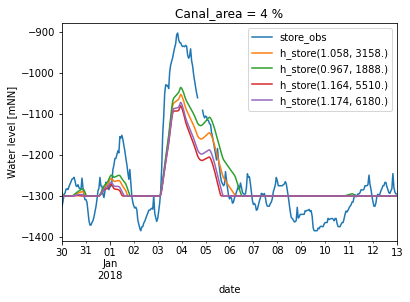

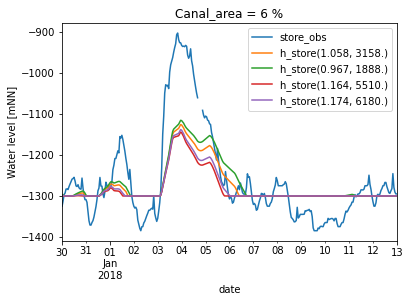

In [10]:
for Canal_area in [4,6]: # set maximum pump gradient [mm]
    z = "2018-01-03"

    t1 = events[z]
    t2 = events[z]+datetime.timedelta(days=14)

    hourly_recharge = data["Prec"][t1:t2]
    days = (t2-t1).days
    hours = days*24 + 1

    tide = data['wl_Knock_Outer'][t1:t2]

    hourly_recharge = hourly_recharge.rolling("12h").mean() # smoothen rainfall signal to account for water redistribution within catchment

    wig = tide*0     # no wind induced gradient -> this may be used to simulate a local flooding in a subcatchment
    x = pd.DataFrame.from_dict(
        {        
            'recharge' : hourly_recharge.fillna(0),
            'h_tide' : tide.fillna(100),
            'wig' : wig.fillna(0),
            'store_obs' : data['wl_LW'][t1:t2].fillna(-2200)
        }
    )

    if x.index[0].month in [10,11,12,1,2,3,4]:
        target = -1300
    else:
        target = -1200

    maxdh = 4500
 #   Canal_area = 4
    advance_pump = 0

    for zzz in canal_par:
        x['h_store'+str(zzz)], q_pump, h_min, flow_rec, pump_cost, store = drain_cap.storage_model(forcing_data = x,
                                                                                                 canal_par = zzz,
                                                                                                 v_store = 0,
                                                                                                 h_store_target = target,
                                                                                                 canal_area = Canal_area,
                                                                                                 h_forecast_pump = advance_pump,
                                                                                                 h_grad_pump_max = maxdh,
                                                                                                 pump_par = pumpcap_fit)
    x = x[x>-2000]
    x.filter(regex = "store").plot(ylabel = "Water level [mNN]", title = "Canal_area = "+str(Canal_area)+" %")
#        result.loc[str(i),:] = [max(x['store']), sum(pump_cost), RCP, slr,prec_increase,event,str(z),Canal_area, advance_pump, raindissagg]

## Short term forecast

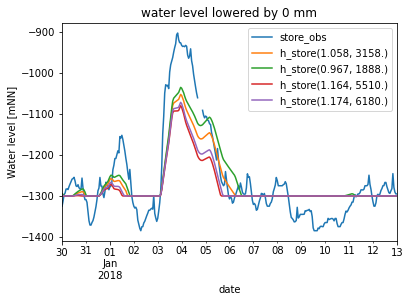

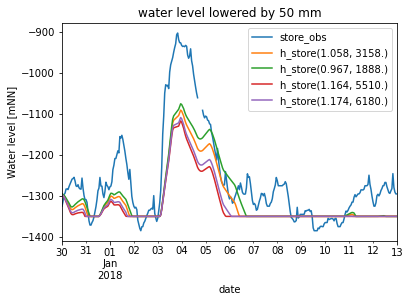

In [11]:
for advance_pump in [0,50]: # set maximum allowed temporarely lowering of canal water level [mm]
    z = "2018-01-03"

    t1 = events[z]
    t2 = events[z]+datetime.timedelta(days=14)

    hourly_recharge = data["Prec"][t1:t2]
    days = (t2-t1).days
    hours = days*24 + 1

    tide = data['wl_Knock_Outer'][t1:t2]

    hourly_recharge = hourly_recharge.rolling("12h").mean() # smoothen rainfall signal to account for water redistribution within catchment

    wig = tide*0     # no wind induced gradient -> this may be used to simulate a local flooding in a subcatchment
    x = pd.DataFrame.from_dict(
        {        
            'recharge' : hourly_recharge.fillna(0),
            'h_tide' : tide.fillna(100),
            'wig' : wig.fillna(0),
            'store_obs' : data['wl_LW'][t1:t2].fillna(-2200)
        }
    )

    if x.index[0].month in [10,11,12,1,2,3,4]:
        target = -1300
    else:
        target = -1200

    maxdh = 4500
    Canal_area = 4
 #   advance_pump = 0

    for zzz in canal_par:
        x['h_store'+str(zzz)], q_pump, h_min, flow_rec, pump_cost, store = drain_cap.storage_model(forcing_data = x,
                                                                                                 canal_par = zzz,
                                                                                                 v_store = 0,
                                                                                                 h_store_target = target,
                                                                                                 canal_area = Canal_area,
                                                                                                 h_forecast_pump = advance_pump,
                                                                                                 h_grad_pump_max = maxdh,
                                                                                                 pump_par = pumpcap_fit)
    x = x[x>-2000]
    x.filter(regex = "store").plot(ylabel = "Water level [mNN]", title = "water level lowered by "+str(advance_pump)+" mm")
#        result.loc[str(i),:] = [max(x['store']), sum(pump_cost), RCP, slr,prec_increase,event,str(z),Canal_area, advance_pump, raindissagg]

## Enchance pump

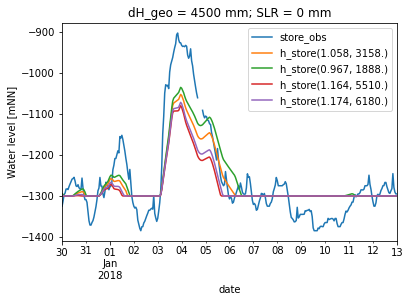

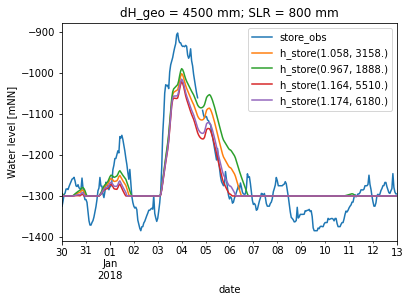

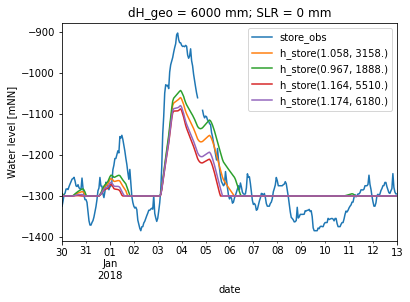

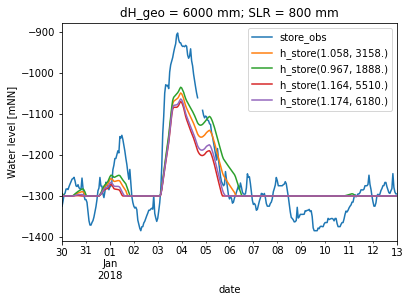

In [12]:
for maxdh in [4500,6000]: # set maximum pump gradient [mm]
    for SLR in [0,800]:
        z = "2018-01-03"

        t1 = events[z]
        t2 = events[z]+datetime.timedelta(days=14)

        hourly_recharge = data["Prec"][t1:t2]
        days = (t2-t1).days
        hours = days*24 + 1

        tide = data['wl_Knock_Outer'][t1:t2]

        hourly_recharge = hourly_recharge.rolling("12h").mean() # smoothen rainfall signal to account for water redistribution within catchment

        wig = tide*0     # no wind induced gradient -> this may be used to simulate a local flooding in a subcatchment
        x = pd.DataFrame.from_dict(
            {        
                'recharge' : hourly_recharge.fillna(0),
                'h_tide' : tide.fillna(100) + SLR,
                'wig' : wig.fillna(0),
                'store_obs' : data['wl_LW'][t1:t2].fillna(-2200)
            }
        )

        if x.index[0].month in [10,11,12,1,2,3,4]:
            target = -1300
        else:
            target = -1200

    #    maxdh = 4500
        Canal_area = 4
        advance_pump = 0

        for zzz in canal_par:
            x['h_store'+str(zzz)], q_pump, h_min, flow_rec, pump_cost, store = drain_cap.storage_model(forcing_data = x,
                                                                                                     canal_par = zzz,
                                                                                                     v_store = 0,
                                                                                                     h_store_target = target,
                                                                                                     canal_area = Canal_area,
                                                                                                     h_forecast_pump = advance_pump,
                                                                                                     h_grad_pump_max = maxdh,
                                                                                                     pump_par = pumpcap_fit)
        x = x[x>-2000]
        x.filter(regex = "store").plot(ylabel = "Water level [mNN]", title = "dH_geo = "+str(maxdh)+" mm; SLR = "+str(SLR)+" mm")
